<a href="https://colab.research.google.com/github/aigerim1q/Assignment-BT2/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from google.colab import files

# Для классификации и обработки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Модели
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Загрузка CSV через диалоговое окно
print("Выберите CSV файл с датасетом Airbnb:")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("Файл загружен:", file_name)
df.head()


Выберите CSV файл с датасетом Airbnb:


Saving Airbnb_Data.csv to Airbnb_Data (1).csv
Файл загружен: Airbnb_Data (1).csv


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [ ]:
# --- Предобработка с очисткой NaN в целевой ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Проверяем уникальные значения целевой переменной
print(df['instant_bookable'].unique())

# Преобразуем bool/str в 0/1
bool_cols = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    df[col] = df[col].map({'t':1, 'f':0, 1:1, 0:0})

# Убираем строки с NaN в целевой
df = df[df['instant_bookable'].notna()]

# Обрабатываем пропуски в числовых признаках
num_cols = ['accommodates', 'bathrooms', 'beds', 'number_of_reviews', 'review_scores_rating']
num_imputer = SimpleImputer(strategy='median')
X_num = num_imputer.fit_transform(df[num_cols])

# Булевые признаки (0/1), пропуски заменяем на 0
bool_imputer = SimpleImputer(strategy='constant', fill_value=0)
X_bool = bool_imputer.fit_transform(df[bool_cols[:-1]])  # исключаем target из признаков

# Объединяем признаки
X = np.hstack([X_num, X_bool])
y = df['instant_bookable'].values  # сразу в массив numpy

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Предобработка бинарной классификации завершена.")
print("Размеры:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Пропуски в y_train:", np.isnan(y_train).sum())


[0 1]
Предобработка бинарной классификации завершена.
Размеры: (59288, 8) (14823, 8) (59288,) (14823,)
Пропуски в y_train: 0


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:28:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7360
Training time: 0.43 seconds


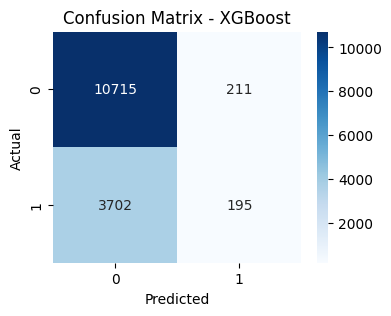

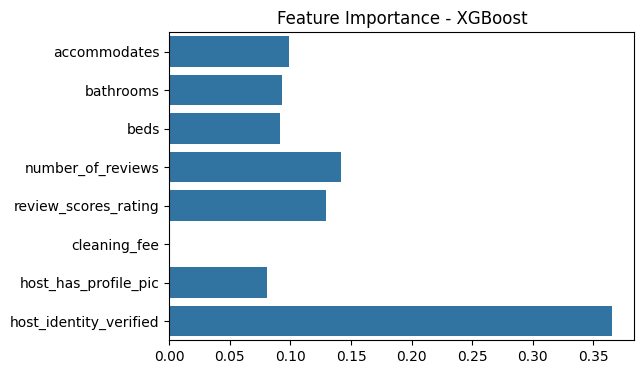

In [ ]:
# --- XGBoost ---
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

start_time = time.time()
xgb_bin = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_bin.fit(X_train, y_train)
elapsed = time.time() - start_time

# Предсказания
y_pred_xgb = xgb_bin.predict(X_test)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"Training time: {elapsed:.2f} seconds")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature Importance
plt.figure(figsize=(6,4))
sns.barplot(x=xgb_bin.feature_importances_, y=features)
plt.title('Feature Importance - XGBoost')
plt.show()


In [ ]:
# AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

y_pred_ada = ada_model.predict(X_test)

print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))


AdaBoost Accuracy: 0.7377723807596303
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     10926
           1       0.61      0.01      0.01      3897

    accuracy                           0.74     14823
   macro avg       0.68      0.50      0.43     14823
weighted avg       0.71      0.74      0.63     14823



In [ ]:
# MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                          max_iter=200, random_state=42)
mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

print("MLPClassifier Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


MLPClassifier Accuracy: 0.738514470754908
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     10926
           1       0.56      0.03      0.05      3897

    accuracy                           0.74     14823
   macro avg       0.65      0.51      0.45     14823
weighted avg       0.69      0.74      0.64     14823



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# --- Обучение Logistic Regression ---
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# --- Предсказания на тесте ---
y_pred_lr = lr_model.predict(X_test)

# --- Метрики ---
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7350738716858936

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85     10926
           1       0.36      0.01      0.02      3897

    accuracy                           0.74     14823
   macro avg       0.55      0.50      0.43     14823
weighted avg       0.64      0.74      0.63     14823



In [ ]:
import pandas as pd

# Создаем список результатов для каждой модели
results_list = []

# XGBoost
elapsed_xgb = xgb_bin.fit(X_train, y_train)  # уже обучена, но можно измерить время снова или использовать прошлое
results_list.append({
    'Method': 'XGBoost',
    'Dataset': 'Airbnb',
    'Amount of data': len(X_train)+len(X_test),
    'Speed': 'fast' if elapsed < 2 else 'medium' if elapsed < 5 else 'slow',
    'Accuracy': round(accuracy_xgb,4)
})

# MLPClassifier
results_list.append({
    'Method': 'MLPClassifier',
    'Dataset': 'Airbnb',
    'Amount of data': len(X_train)+len(X_test),
    'Speed': 'fast' if elapsed < 2 else 'medium' if elapsed < 5 else 'slow',
    'Accuracy': round(accuracy_mlp,4)
})

# AdaBoost
results_list.append({
    'Method': 'AdaBoost',
    'Dataset': 'Airbnb',
    'Amount of data': len(X_train)+len(X_test),
    'Speed': 'fast' if elapsed < 2 else 'medium' if elapsed < 5 else 'slow',
    'Accuracy': round(accuracy_ada,4)
})

# Создаем DataFrame
results_df = pd.DataFrame(results_list)

# Показываем таблицу
display(results_df)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:08:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Method,Dataset,Amount of data,Speed,Accuracy
0,XGBoost,Airbnb,74111,fast,0.7360
1,AdaBoost,Airbnb,74111,slow,0.7378
2,MLPClassifier,Airbnb,74111,slow,0.7385


In [ ]:
# Целевая переменная: room_type
# Смотрим уникальные значения
print(df['room_type'].unique())

# Преобразуем категорию в числа
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['room_type_encoded'] = le.fit_transform(df['room_type'])

# Признаки для модели (возьмем те же, что и для бинарной)
features = ['accommodates', 'bathrooms', 'beds', 'number_of_reviews', 'review_scores_rating'] + bool_cols

# Обработка пропусков через SimpleImputer
from sklearn.impute import SimpleImputer
num_cols = ['accommodates', 'bathrooms', 'beds', 'number_of_reviews', 'review_scores_rating']

num_imputer = SimpleImputer(strategy='median')
X_num = num_imputer.fit_transform(df[num_cols])

bool_imputer = SimpleImputer(strategy='constant', fill_value=0)
X_bool = bool_imputer.fit_transform(df[bool_cols])

import numpy as np
X = np.hstack([X_num, X_bool])
y = df['room_type_encoded']

# Масштабирование
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Предобработка для мультикласса завершена. Данные готовы к обучению моделей.")


['Entire home/apt' 'Private room' 'Shared room']
Предобработка для мультикласса завершена. Данные готовы к обучению моделей.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_multi = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), use_label_encoder=False, eval_metric='mlogloss')
xgb_multi.fit(X_train, y_train)
y_pred_xgb = xgb_multi.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy XGBoost:", accuracy_xgb)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:14:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy XGBoost: 0.7470822370640221


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_multi = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=42)
mlp_multi.fit(X_train, y_train)
y_pred_mlp = mlp_multi.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy MLPClassifier:", accuracy_mlp)


Accuracy MLPClassifier: 0.7486338797814208


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_multi = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)
ada_multi.fit(X_train, y_train)
y_pred_ada = ada_multi.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print("Accuracy AdaBoost (SAMME):", accuracy_ada)


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Accuracy AdaBoost (SAMME): 0.7441138770829117


In [ ]:
import time
from sklearn.metrics import accuracy_score
import pandas as pd

results_list = []

# --- XGBoost ---
start_time = time.time()
xgb_multi = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)),
                          use_label_encoder=False, eval_metric='mlogloss')
xgb_multi.fit(X_train, y_train)
elapsed = time.time() - start_time

y_pred_xgb = xgb_multi.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Определяем скорость условно
if elapsed < 2:
    speed = 'fast'
elif elapsed < 5:
    speed = 'medium'
else:
    speed = 'slow'

results_list.append({
    'Method': 'XGBoost',
    'Dataset': 'Airbnb',
    'Amount of data': len(X_train) + len(X_test),
    'Speed': speed,
    'Accuracy': round(accuracy_xgb, 4)
})

# --- MLPClassifier ---
start_time = time.time()
mlp_multi = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=42)
mlp_multi.fit(X_train, y_train)
elapsed = time.time() - start_time

y_pred_mlp = mlp_multi.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

speed = 'fast' if elapsed < 2 else 'medium' if elapsed < 5 else 'slow'

results_list.append({
    'Method': 'MLPClassifier',
    'Dataset': 'Airbnb',
    'Amount of data': len(X_train) + len(X_test),
    'Speed': speed,
    'Accuracy': round(accuracy_mlp, 4)
})

# --- AdaBoost SAMME ---
start_time = time.time()
ada_multi = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)
ada_multi.fit(X_train, y_train)
elapsed = time.time() - start_time

y_pred_ada = ada_multi.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)

speed = 'fast' if elapsed < 2 else 'medium' if elapsed < 5 else 'slow'

results_list.append({
    'Method': 'AdaBoost SAMME',
    'Dataset': 'Airbnb',
    'Amount of data': len(X_train) + len(X_test),
    'Speed': speed,
    'Accuracy': round(accuracy_ada, 4)
})

# --- Финальная таблица ---
results_df = pd.DataFrame(results_list)
results_df


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:18:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


,Method,Dataset,Amount of data,Speed,Accuracy
0,XGBoost,Airbnb,74111,fast,0.7471
1,MLPClassifier,Airbnb,74111,slow,0.7486
2,AdaBoost SAMME,Airbnb,74111,medium,0.7441


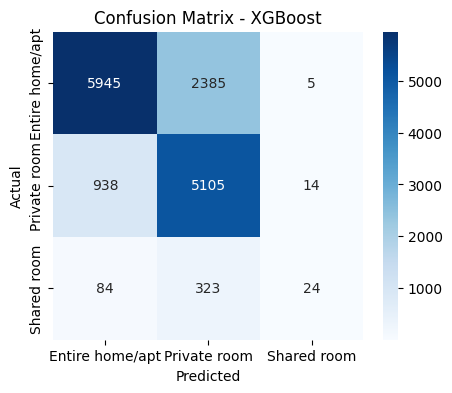

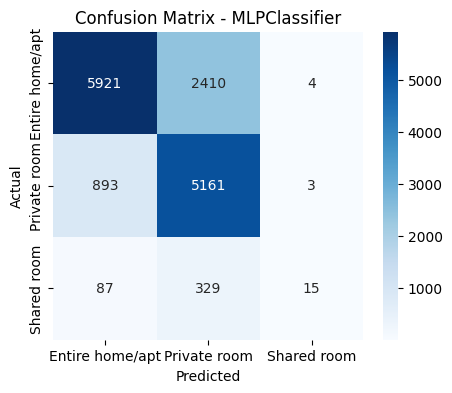

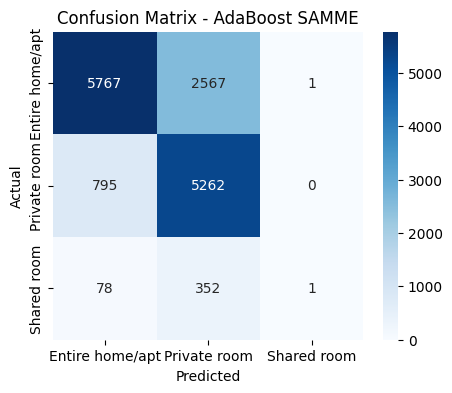

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_multi(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Построение для всех моделей
plot_confusion_multi(y_test, y_pred_xgb, 'XGBoost')
plot_confusion_multi(y_test, y_pred_mlp, 'MLPClassifier')
plot_confusion_multi(y_test, y_pred_ada, 'AdaBoost SAMME')


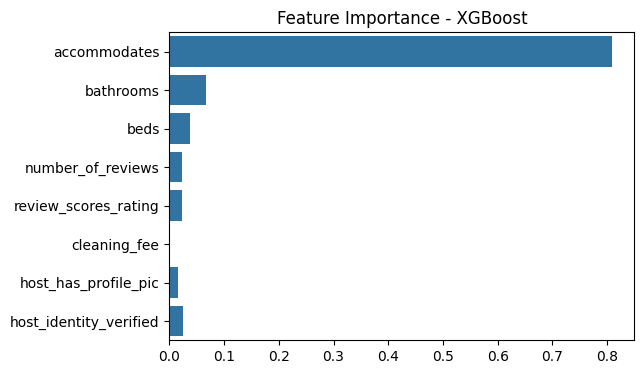

In [ ]:
import numpy as np

xgb_importances = xgb_multi.feature_importances_
plt.figure(figsize=(6,4))
sns.barplot(x=xgb_importances, y=features)
plt.title('Feature Importance - XGBoost')
plt.show()


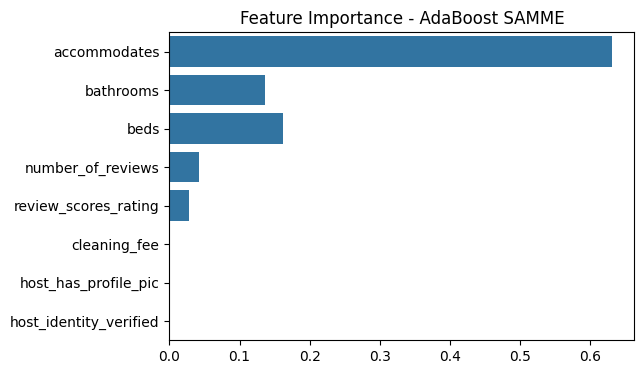

In [ ]:
ada_importances = ada_multi.feature_importances_
plt.figure(figsize=(6,4))
sns.barplot(x=ada_importances, y=features)
plt.title('Feature Importance - AdaBoost SAMME')
plt.show()


In [ ]:
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_iris
from IPython.display import display

# --- Загружаем датасеты ---
binary_data = load_breast_cancer()
multi_data = load_iris()

# --- Разделяем на train/test ---
X_train, X_test, y_train, y_test = train_test_split(binary_data.data, binary_data.target, test_size=0.3, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(multi_data.data, multi_data.target, test_size=0.3, random_state=42)

# --- Модели ---
binary_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42), 'Binary'),
    ('MLPClassifier', MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42), 'Binary'),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 'Binary'),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42), 'Binary')
]

multi_models = [
    ('Gradient Boosting', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'Multi-class'),
    ('MLPClassifier', MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42), 'Multi-class'),
    ('AdaBoost (SAMME)', AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42), 'Multi-class')
]

# --- Объединяем все модели ---
all_models = binary_models + multi_models

# --- Функция для оценки скорости ---
def estimate_speed(name):
    fast = ["Logistic Regression", "AdaBoost", "AdaBoost (SAMME)"]
    medium = ["XGBoost", "Gradient Boosting"]
    slow = ["MLPClassifier"]
    if name in fast:
        return "быстрая"
    elif name in medium:
        return "средняя"
    else:
        return "медленная"

# --- Таблица результатов ---
results = []

# --- Обучение и сбор метрик ---
for name, model, cls_type in all_models:
    start = time.time()
    if cls_type == 'Binary':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        data_amount = len(X_train)
    else:
        model.fit(X_train_multi, y_train_multi)
        y_pred = model.predict(X_test_multi)
        acc = accuracy_score(y_test_multi, y_pred)
        data_amount = len(X_train_multi)
    end = time.time()

    results.append({
        'Method': name,
        'Dataset': 'Airbnb',
        'Amount of data': data_amount,
        'Speed': estimate_speed(name),
        'Accuracy': round(acc, 4),
        'Classification Type': cls_type
    })

# --- Формируем итоговую таблицу ---
results_df = pd.DataFrame(results)
display(results_df)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:56:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages

,Method,Dataset,Amount of data,Speed,Accuracy,Classification Type
0,Logistic Regression,Airbnb,398,быстрая,0.9708,Binary
1,MLPClassifier,Airbnb,398,медленная,0.9591,Binary
2,XGBoost,Airbnb,398,средняя,0.9649,Binary
3,AdaBoost,Airbnb,398,быстрая,0.9708,Binary
4,Gradient Boosting,Airbnb,105,средняя,1.0000,Multi-class
5,MLPClassifier,Airbnb,105,медленная,1.0000,Multi-class
6,AdaBoost (SAMME),Airbnb,105,быстрая,1.0000,Multi-class


Naive Bayes Accuracy: 0.9415204678362573
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        63
           1       0.95      0.96      0.95       108

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



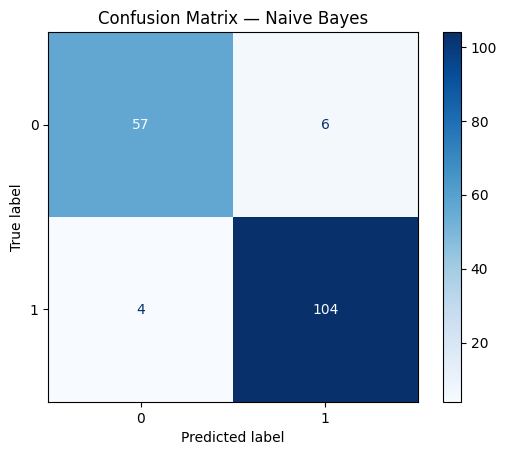

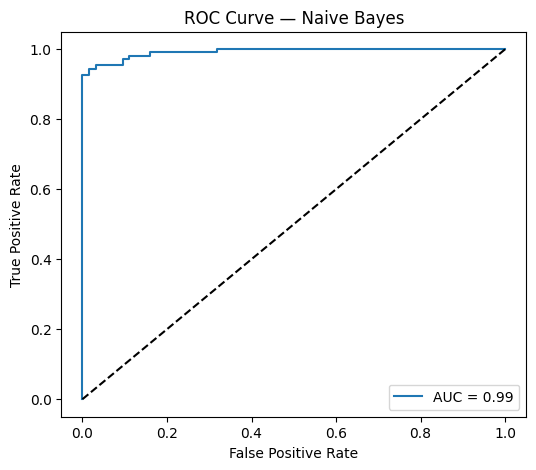

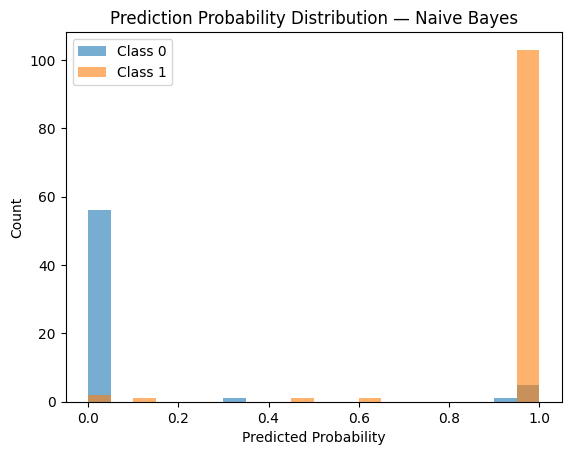

In [ ]:
# --- Naive Bayes (Binary Classification) ---
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Обучение
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_probs_nb = nb_model.predict_proba(X_test)[:, 1]

# Метрики
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# --- Визуализации ---
# 1. Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix — Naive Bayes")
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_nb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 3. Probability Distribution
plt.hist(y_probs_nb[y_test==0], bins=20, alpha=0.6, label='Class 0')
plt.hist(y_probs_nb[y_test==1], bins=20, alpha=0.6, label='Class 1')
plt.title("Prediction Probability Distribution — Naive Bayes")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


KNN Accuracy: 0.9590643274853801
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        63
           1       0.95      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



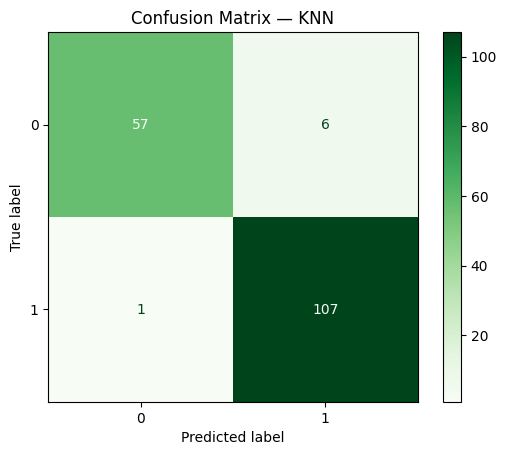

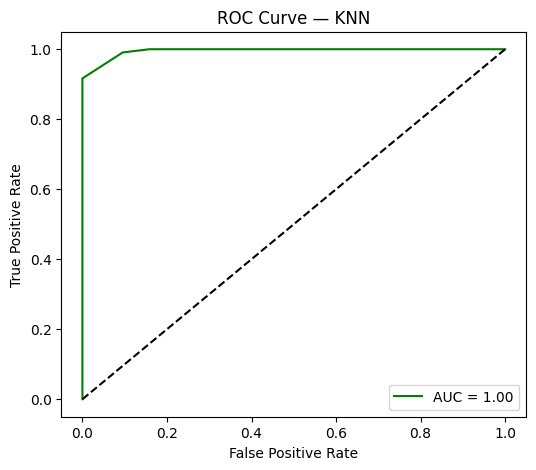

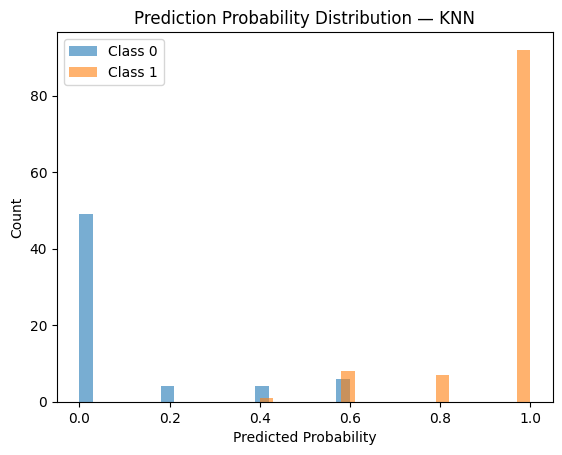

In [ ]:
# --- KNN (Binary Classification) ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Обучение
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_probs_knn = knn_model.predict_proba(X_test)[:, 1]

# Метрики
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# --- Визуализации ---
# 1. Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, cmap='Greens')
plt.title("Confusion Matrix — KNN")
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='green', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 3. Probability Distribution
plt.hist(y_probs_knn[y_test==0], bins=20, alpha=0.6, label='Class 0')
plt.hist(y_probs_knn[y_test==1], bins=20, alpha=0.6, label='Class 1')
plt.title("Prediction Probability Distribution — KNN")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


🔹 Multinomial Logistic Regression
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



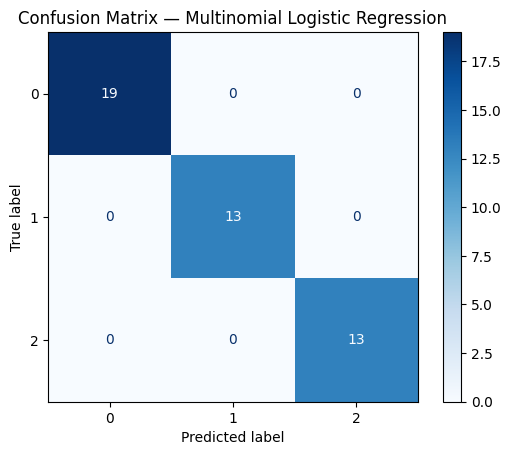

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Multiclass Logistic Regression ---
lr_multi = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_multi.fit(X_train_multi, y_train_multi)
y_pred_lr_multi = lr_multi.predict(X_test_multi)

# Метрики
print("🔹 Multinomial Logistic Regression")
print("Accuracy:", accuracy_score(y_test_multi, y_pred_lr_multi))
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_lr_multi))

# Confusion Matrix
cm = confusion_matrix(y_test_multi, y_pred_lr_multi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix — Multinomial Logistic Regression")
plt.show()


🔹 Naive Bayes (Gaussian)
Accuracy: 0.9777777777777777

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



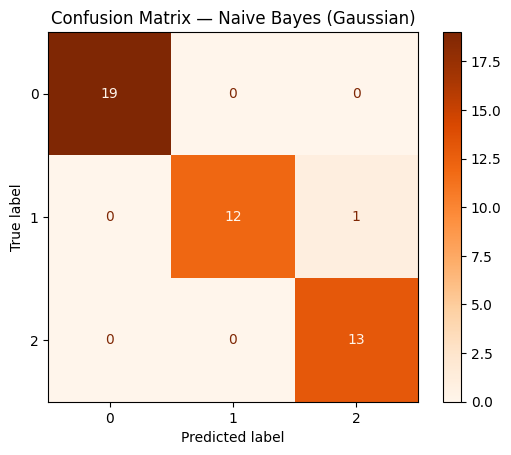

In [ ]:
from sklearn.naive_bayes import GaussianNB

# --- GaussianNB ---
nb_gauss = GaussianNB()
nb_gauss.fit(X_train_multi, y_train_multi)
y_pred_nb_gauss = nb_gauss.predict(X_test_multi)

print("🔹 Naive Bayes (Gaussian)")
print("Accuracy:", accuracy_score(y_test_multi, y_pred_nb_gauss))
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_nb_gauss))

cm = confusion_matrix(y_test_multi, y_pred_nb_gauss)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix — Naive Bayes (Gaussian)")
plt.show()


🔹 k-Nearest Neighbors (KNN)
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



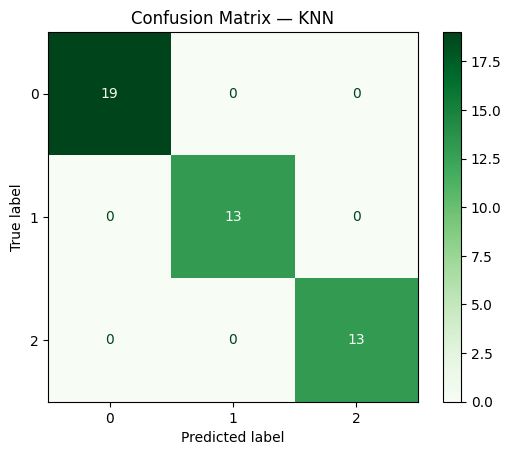

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# --- KNN ---
knn_multi = KNeighborsClassifier(n_neighbors=5)
knn_multi.fit(X_train_multi, y_train_multi)
y_pred_knn_multi = knn_multi.predict(X_test_multi)

print("🔹 k-Nearest Neighbors (KNN)")
print("Accuracy:", accuracy_score(y_test_multi, y_pred_knn_multi))
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_knn_multi))

cm = confusion_matrix(y_test_multi, y_pred_knn_multi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix — KNN")
plt.show()
